# Microstructure porosity analysis based on computer vision

In [2]:
import numpy as np
import pandas as pd
import cv2

import scipy
import scipy.misc

import scipy.stats as stats
from scipy.stats import kurtosis

import skimage
from skimage import filters
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

## Large scale image (Aluminum, 300 microns)

(1536, 1690)


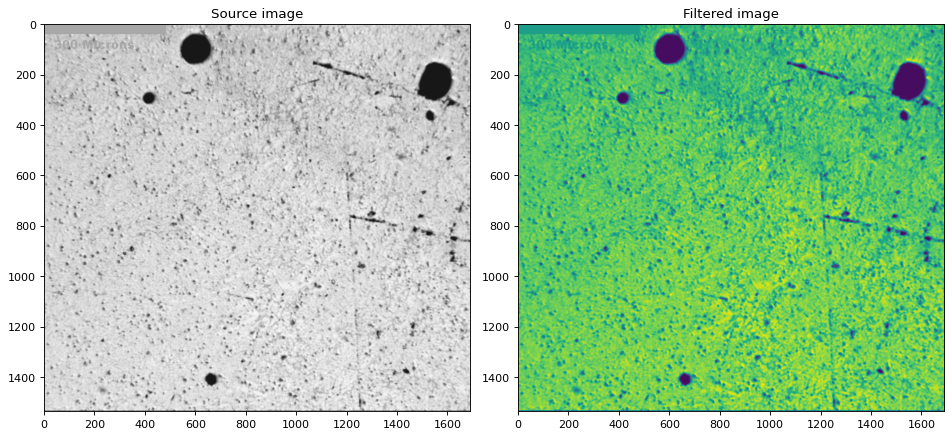

(1536, 1690)


In [71]:
# Preprocessing
src = cv2.imread('/src_images/GW B2 50x.jpg', 0)[:,10:1700]
print(src.shape)
#blur = skimage.filters.gaussian(src, sigma=0.09) # gaussian blur
src_denoised = filters.median(src,footprint=np.ones((5,5))) # median filter

fig = plt.figure(figsize=(12,8), dpi=80)
plt.subplot(121)
plt.imshow(src,cmap='Greys_r')
plt.title('Source image')
plt.subplot(122)
plt.imshow(src_denoised)
plt.title('Filtered image')
plt.tight_layout()
plt.show()

print(src_denoised.shape)

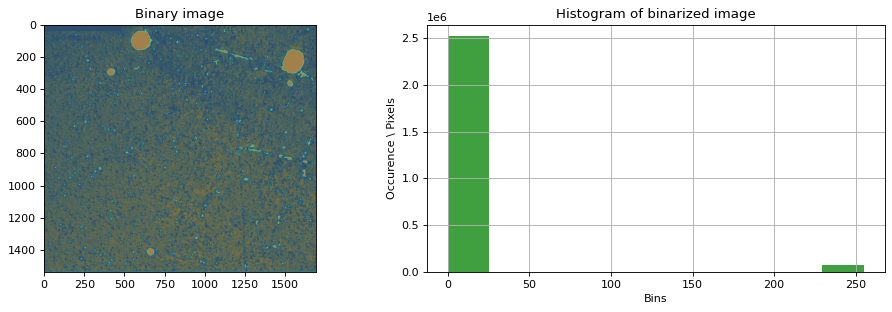


Source image area = 2595840 px

Total light area = 2521447 px2
Total dark area = 74393 px2

Fraction = 2.950409031004816 %


In [74]:
# Image binarization to calculate areas
ret, thresh = cv2.threshold(src_denoised,60,255,cv2.THRESH_BINARY)
thresh = 255-thresh

hist, bin_edges = np.histogram(thresh.reshape(-1,1),density=False)

fig = plt.figure(figsize=(12,4), dpi=80)
plt.subplot(121)
plt.imshow(src,cmap='viridis')
plt.imshow(thresh,alpha=0.5,cmap='viridis')
plt.title('Binary image')
plt.subplot(122)
n, bins, patches = plt.hist(thresh.reshape(-1,1),10,density=False,facecolor='g',alpha=0.75)
plt.xlabel('Bins')
plt.ylabel('Occurence \ Pixels')
plt.title('Histogram of binarized image')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSource image area = {} px".format(src.shape[0]*src.shape[1]))
print("\nTotal light area = {} px2".format(hist[0]))
print("Total dark area = {} px2".format(hist[-1]))
print("\nFraction = {} %".format(100*hist[-1]/hist[0]))

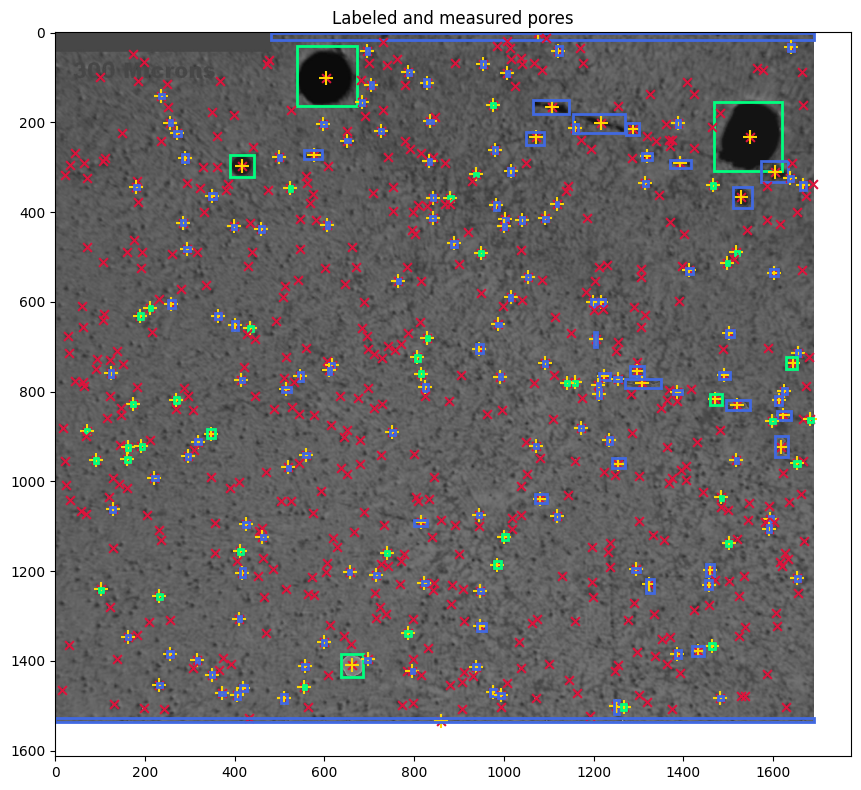

In [105]:
# Labeling and analysis of detected pores
label_image = label(thresh)
image_label_overlay = label2rgb(label_image, image=src)

MAX_AREA = 50000
MIN_AREA = 50

CRITICAL_ECCENTRICITY = 0.6

area_of_circular_pores = []
perimeter_of_circular_pores = []
equivalent_circular_diameter = []
eccentricity_of_circular_pores = []

number_of_circular_pores = 0
number_of_elliptical_pores = 0
total_number_of_pores = 0

#-----------------------------------------------------------------

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.imshow(src,cmap='gray')
ax.imshow(label_image,cmap='gray',alpha=0.5)

for region in regionprops(label_image):
    total_number_of_pores = total_number_of_pores + 1
    plt.scatter(region.centroid[1],region.centroid[0],marker='x',s=40,c='crimson')
    if (region.area <= MAX_AREA and region.area >= MIN_AREA):
        plt.scatter(region.centroid[1],region.centroid[0],marker='+',s=100,c='gold')
        minr, minc, maxr, maxc = region.bbox
        if(region.eccentricity < CRITICAL_ECCENTRICITY):
            rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,
                                  fill=False, edgecolor='springgreen', linewidth=2)
            number_of_circular_pores = number_of_circular_pores + 1
            area_of_circular_pores.append(region.area)
            equivalent_circular_diameter.append(region.equivalent_diameter)
            perimeter_of_circular_pores.append(region.perimeter)
            eccentricity_of_circular_pores.append(region.eccentricity)

        else:
            rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,
                                  fill=False, edgecolor='royalblue', linewidth=2)
            number_of_elliptical_pores = number_of_elliptical_pores + 1
        ax.add_patch(rect)
ax.set_title('Labeled and measured pores')

plt.tight_layout()
plt.show()

In [75]:
print("\nNumber of circular pores = {}".format(number_of_circular_pores))
print("Number of elliptical pores = {}".format(number_of_elliptical_pores))
number_of_ignored_pores = total_number_of_pores-(number_of_elliptical_pores+number_of_circular_pores)
print("Number of ignored pores = {}".format(number_of_ignored_pores))
print("\nTotal number of pores = {}".format(total_number_of_pores))


Number of circular pores = 45
Number of elliptical pores = 142
Number of ignored pores = 443

Total number of pores = 630


In [76]:
# Obtained data

print("\nTotal area of circular pores = {} px2".format(int(np.sum(area_of_circular_pores))))
print("Total perimeter of circular pores = {} px".format(int(np.sum(perimeter_of_circular_pores))))

print("\nMedian equivalent diameter of circular pores = {} px".format(int(np.median(perimeter_of_circular_pores))))
print("Mean eccentricity of circular pores = {}".format(np.round(np.mean(eccentricity_of_circular_pores),2)))


pore_area = int(np.sum(area_of_circular_pores))
image_area = src.shape[0]*src.shape[1]

print("\nPore area  = {} px2".format(pore_area))
print("Image area = {} px2".format(image_area))

print("\nPore fraction = {} %".format(100*pore_area/image_area))


Total area of circular pores = 36730 px2
Total perimeter of circular pores = 2693 px

Median equivalent diameter of circular pores = 30 px
Mean eccentricity of circular pores = 0.48

Pore area  = 36730 px2
Image area = 2595840 px2

Pore fraction = 1.4149562376725837 %


(1536, 1690)
(153, 169)


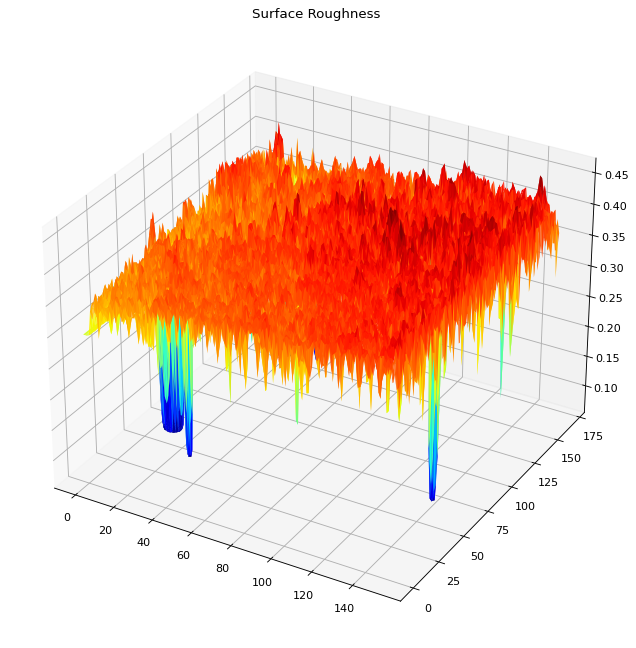

In [79]:
# Surface roughness analysis
src_resized = resize(src, (src.shape[0]//10,src.shape[1]//10),anti_aliasing=True)

print(src.shape)
print(src_resized.shape)

xx, yy = np.mgrid[0:src_resized.shape[0],0:src_resized.shape[1]]
fig = plt.figure(figsize=(14,10), dpi=80,)
ax = plt.axes(projection='3d')
ax.plot_surface(xx,yy,src_resized,rstride=1,cstride=1,cmap='jet',linewidth=1)
ax.set_title('Surface Roughness')
plt.show()

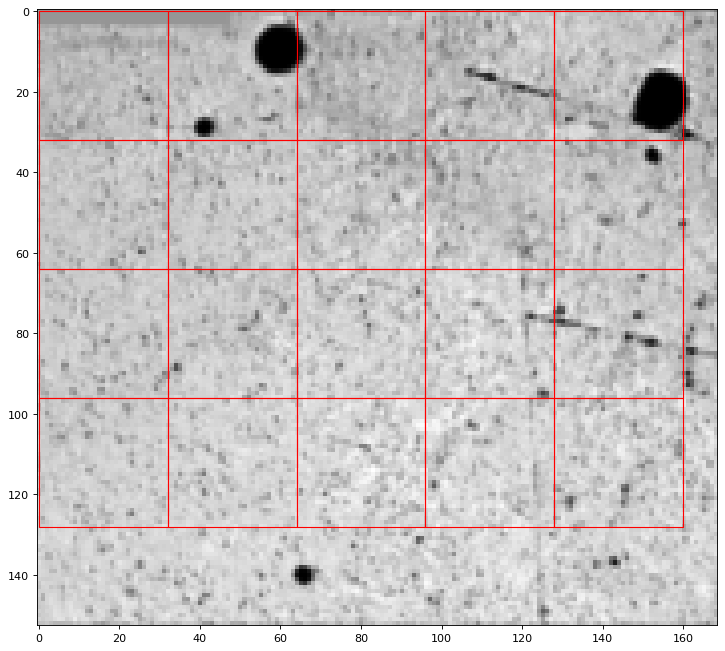

In [96]:
# Sliding window
window_size = 32

x_start = 0
x_stop = np.shape(src_resized)[1] # number of columns
y_start = 0
y_stop = np.shape(src_resized)[0] # number of rows

fig = plt.figure(figsize=(14,10), dpi=80)
ax = fig.add_subplot(111)
ax.imshow(src_resized,cmap='gray')

for i in range((int)((x_stop-x_start)/window_size)):
    for j in range((int)((y_stop-y_start)/window_size)):
        rect = mpatches.Rectangle((i*window_size,j*window_size),window_size,window_size,\
                                 linewidth=1,edgecolor='red',facecolor='none')

        ax.add_patch(rect)
plt.show()

In [97]:
hist_data = []

for i in range((int)((x_stop-x_start)/window_size)):
    for j in range((int)((y_stop-y_start)/window_size)):
        hist_data.append(src_resized[i*window_size:window_size*(i+1),\
                                     j*window_size:window_size*(j+1)])
print(np.shape(hist_data))
print("number of crops = " + str(len(hist_data)))

(20,)
number of crops = 20


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


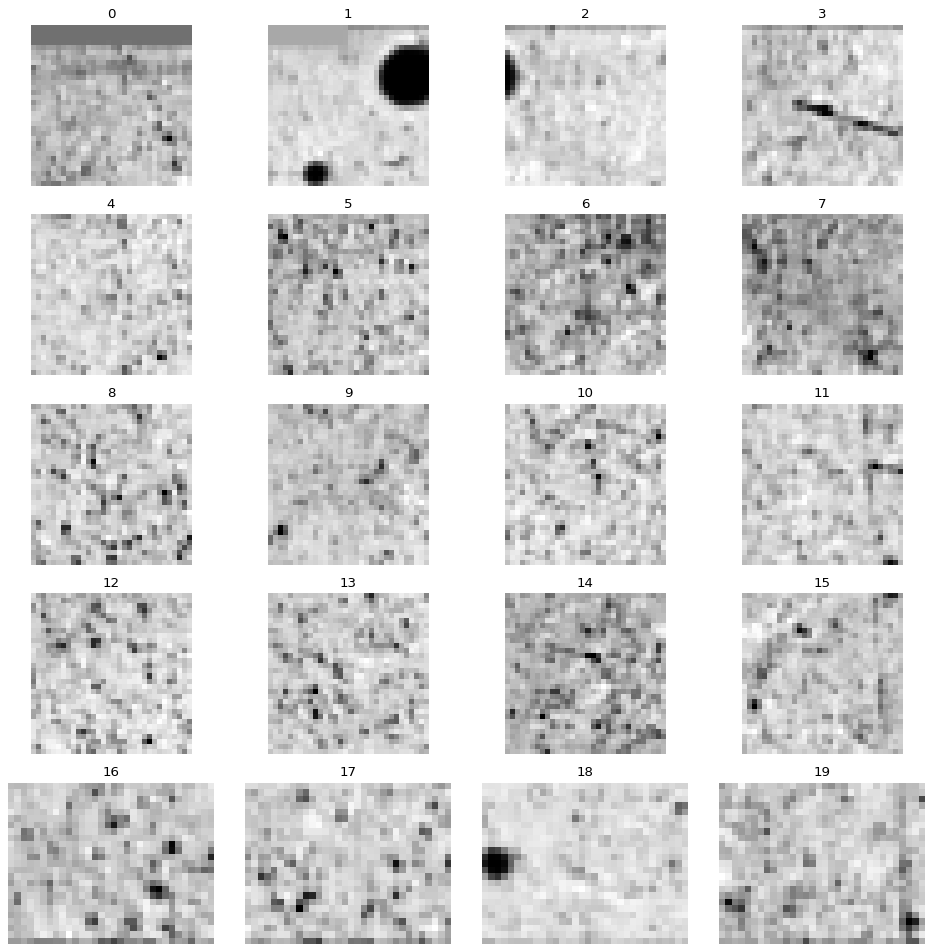

In [98]:

fig = plt.figure(figsize=(12,12), dpi=80)

for i in range(len(hist_data)):
    plt.subplot((int)((x_stop-x_start)/window_size),(int)((y_stop-y_start)/window_size),i+1)
    plt.imshow(hist_data[i], cmap='gray')
    plt.title((str)(i))
    plt.axis('off')
plt.tight_layout()
plt.show()

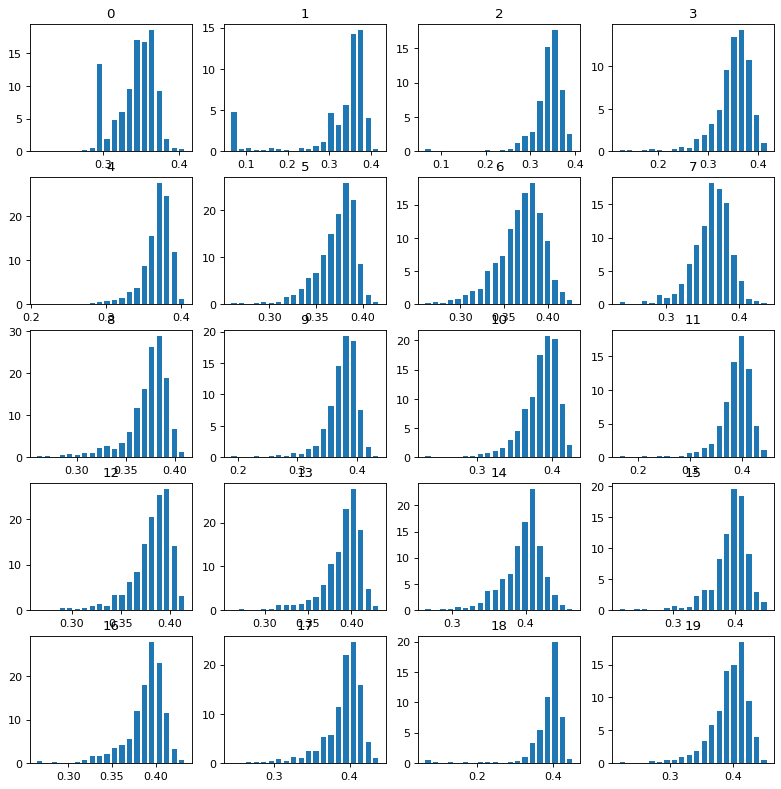

In [99]:

fig = plt.figure(figsize=(12,12), dpi=80)

for i in range(len(hist_data)):
    hist, bins = np.histogram(hist_data[i],bins=20,density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot((int)((x_stop-x_start)/window_size),(int)((y_stop-y_start)/window_size),i+1),

    plt.bar(center, hist, align='center', width=width),plt.title((str)(i)) # hist of the cropped rregion
plt.show()

In [100]:
mean_list = []
std_dev_list = []

for i in range(len(hist_data)):
    mean_list.append(np.mean(hist_data[i]))
    std_dev_list.append(np.std(hist_data[i]))

heat_map_mean = np.reshape(mean_list,(5, 4))
heat_map_std = np.reshape(std_dev_list,(5, 4))

(iH, iW) = heat_map_mean.shape[:2] # the same dimensions for heat_map_std

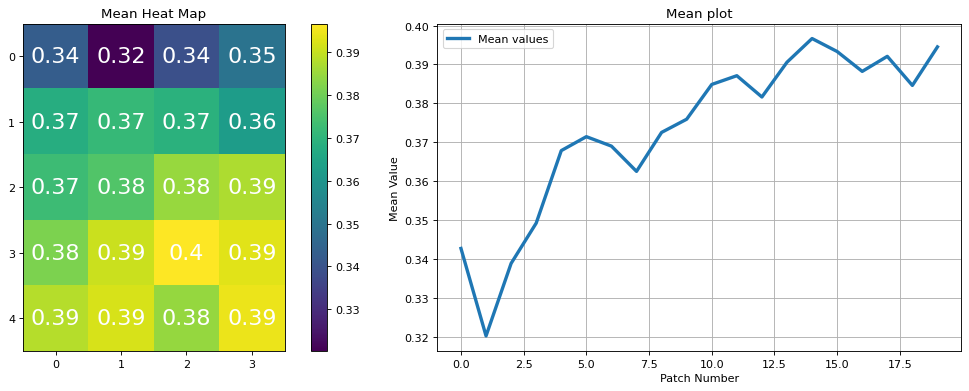

In [101]:
fig = plt.figure(figsize=(14,5), dpi=80)
plt.subplot(121)
plt.imshow(heat_map_mean),plt.colorbar()
plt.title('Mean Heat Map')
for i in range(iH):
    for j in range(iW):
        plt.text(j,i,np.round(heat_map_mean[i,j],2),ha="center",va="center",color="w",fontsize=20)

plt.subplot(122)
plt.title('Mean plot')
plt.plot(np.reshape(heat_map_mean,(iH*iW,1)),label='Mean values',linewidth=3)
plt.xlabel('Patch Number'),plt.ylabel('Mean Value')
plt.grid(),plt.legend()
plt.tight_layout()
plt.show()

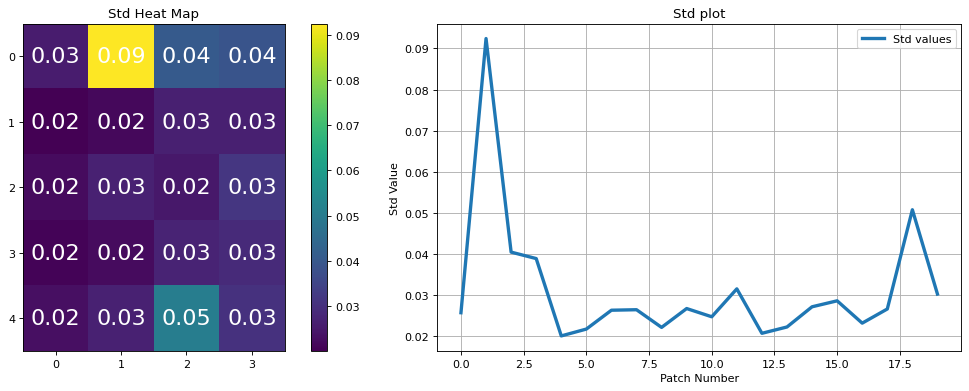

In [102]:
fig = plt.figure(figsize=(14,5), dpi=80)
plt.subplot(121)
plt.imshow(heat_map_std),plt.colorbar()
plt.title('Std Heat Map')
for i in range(iH):
    for j in range(iW):
        plt.text(j,i,np.round(heat_map_std[i,j],2),ha="center",va="center",color="w",fontsize=20)

plt.subplot(122)
plt.title('Std plot')
plt.plot(np.reshape(heat_map_std,(iH*iW,1)),label='Std values',linewidth=3)
plt.xlabel('Patch Number'),plt.ylabel('Std Value')
plt.grid(),plt.legend()
plt.tight_layout()
plt.show()

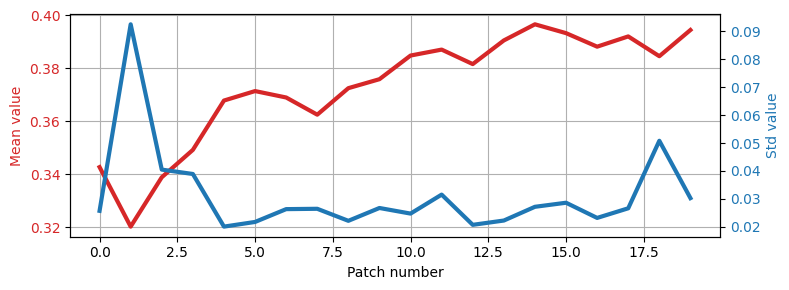

In [104]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)

color = 'tab:red'
ax1.set_xlabel('Patch number')
ax1.set_ylabel('Mean value', color=color)
ax1.plot(np.reshape(heat_map_mean,(iH*iW,1)),label='Mean values',linewidth=3,color=color)
ax1.tick_params(axis='y',labelcolor=color)
plt.grid()

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Std value', color=color)
ax2.plot(np.reshape(heat_map_std,(iH*iW,1)),label='Mean values',linewidth=3,color=color)
ax2.tick_params(axis='y',labelcolor=color)

fig.tight_layout()
#plt.grid()
plt.show()

## Small scale image (Aluminum, 30 microns)

(1536, 2048, 3)
(1536, 2048)


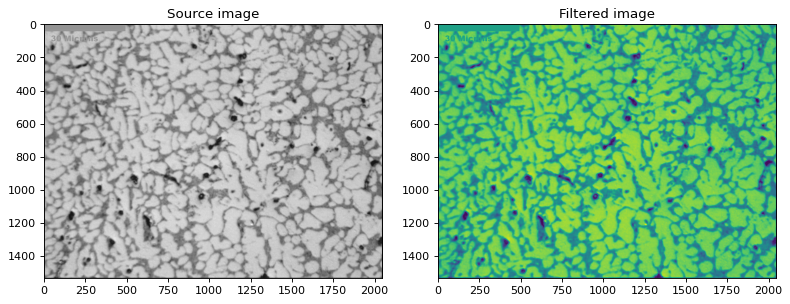

In [132]:
# Preprocessing


rgb_src = cv2.imread('/src_images/GW B2 500x.jpg')
print(rgb_src.shape)
src = cv2.cvtColor(rgb_src,cv2.COLOR_BGR2GRAY)
#src = cv2.equalizeHist(src)
src_denoised = filters.median(src,footprint=np.ones((5,5)))
#blur = skimage.filters.gaussian(src_denoised, sigma=0.5)
print(src_denoised.shape)

fig = plt.figure(figsize=(10,8), dpi=80)
plt.subplot(121)
plt.imshow(src,cmap='gray')
plt.title('Source image')
plt.subplot(122)
plt.imshow(src_denoised)
plt.title('Filtered image')
plt.tight_layout()
plt.show()

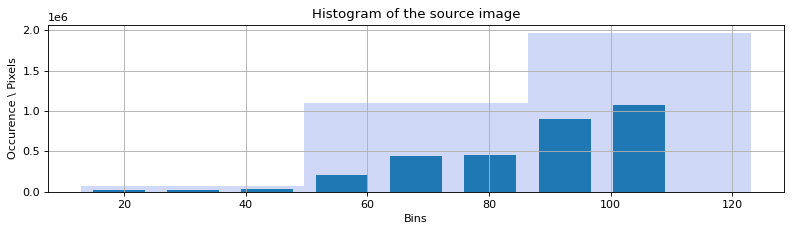

In [112]:
fig = plt.figure(figsize=(10,3), dpi=80)
n, bins, patches = plt.hist(src_denoised.reshape(-1,1),bins=3,density=False,facecolor='royalblue',alpha=0.25)
hist, bins = np.histogram(src_denoised,bins=9,density=False)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Bins')
plt.ylabel('Occurence \ Pixels')
plt.title('Histogram of the source image')
plt.grid()
plt.tight_layout()
plt.show()

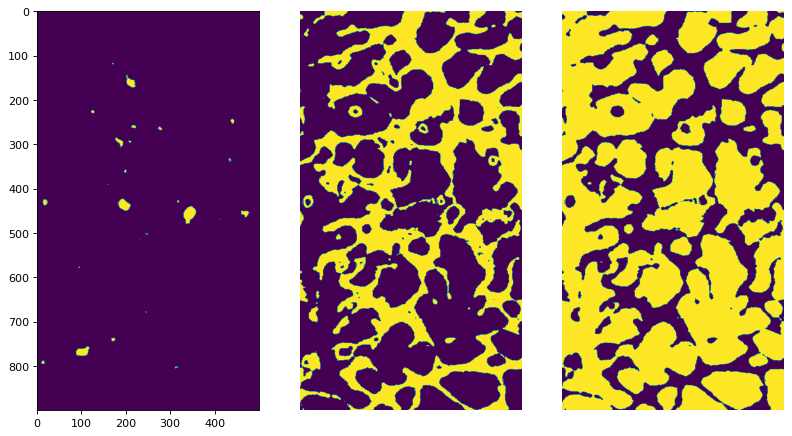

In [113]:
part_1 = cv2.inRange(src,0,40)
part_2 = cv2.inRange(src,45,85)
part_3 = cv2.inRange(src,85,255)

MIN_Y = 300; MAX_Y = 1200
MIN_X = 1300; MAX_X = 1800

fig = plt.figure(figsize=(10,8), dpi=80)
plt.subplot(131)
plt.imshow(part_1[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.subplot(132)
plt.imshow(part_2[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.axis('off')
plt.subplot(133)
plt.imshow(part_3[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.tight_layout()
plt.axis('off')
plt.show()

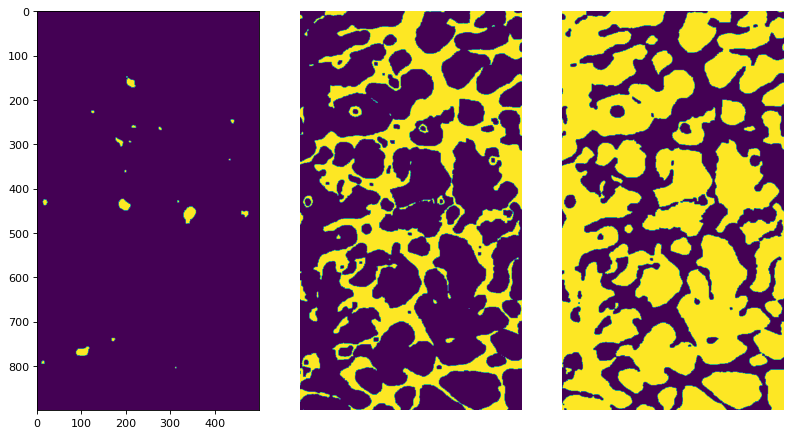

In [114]:
## cleared thresholds
#
# part_1 = "black" fraction ->> opening = erosion + dilation
# part_2 = "gray" fraction  ->> closing = dilation + erosion
# part_1 = "white" fraction ->> hard opening = erosion + erosion + dilation

kernel = np.ones((3,3),np.uint8)

part_1_clear = cv2.erode(part_1,kernel,iterations = 1)
part_1_clear = cv2.dilate(part_1_clear,kernel,iterations = 1)

part_2_clear = cv2.dilate(part_2,kernel,iterations = 1)
part_2_clear = cv2.erode(part_2_clear,kernel,iterations = 2)

part_3_clear = cv2.erode(part_3,kernel,iterations = 2)
part_3_clear = cv2.dilate(part_3_clear,kernel,iterations = 1)

fig = plt.figure(figsize=(10,8), dpi=80)
plt.subplot(131)
plt.imshow(part_1_clear[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.subplot(132)
plt.imshow(part_2_clear[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.axis('off')
plt.subplot(133)
plt.imshow(part_3_clear[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.tight_layout()
plt.axis('off')
plt.show()

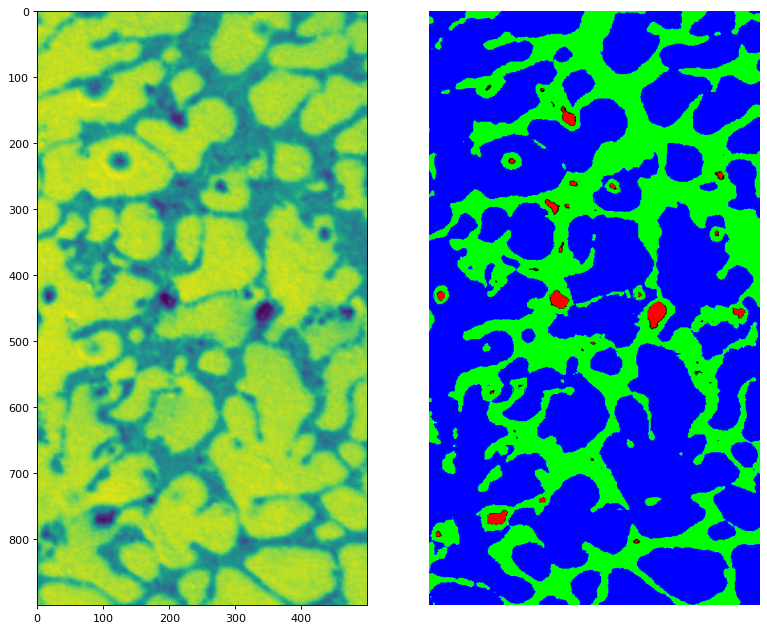

In [115]:
## Stitch as RGB

# RAW version
raw_rgb = np.zeros(rgb_src.shape, dtype=int)

raw_rgb[:,:,0] = part_1
raw_rgb[:,:,1] = part_2
raw_rgb[:,:,2] = part_3

# CLEAR version
clear_rgb = np.zeros(rgb_src.shape, dtype=int)

clear_rgb[:,:,0] = part_1_clear
clear_rgb[:,:,1] = part_2_clear
clear_rgb[:,:,2] = part_3_clear

fig = plt.figure(figsize=(10,8), dpi=80)
plt.subplot(121)
plt.imshow(src[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.subplot(122)
plt.imshow(raw_rgb[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.tight_layout()
plt.axis('off')
plt.show()

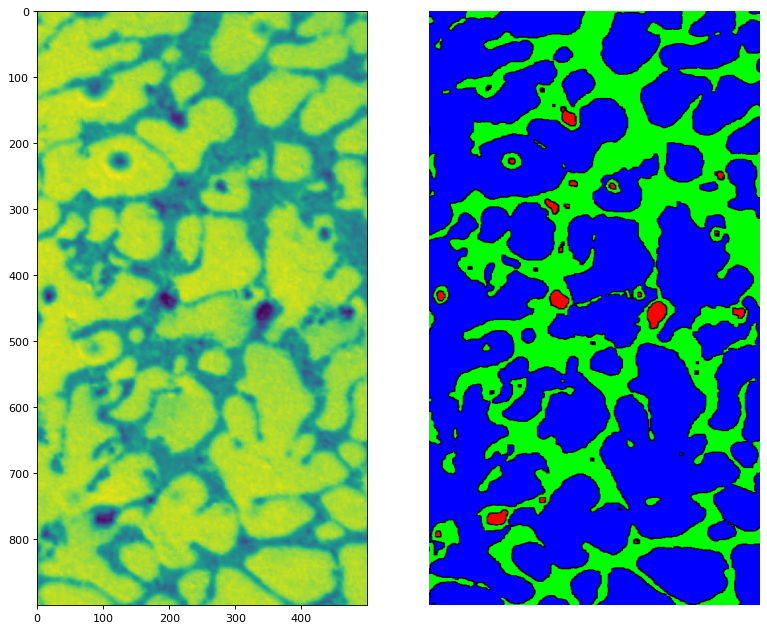

In [116]:
fig = plt.figure(figsize=(10,8), dpi=80)
plt.subplot(121)
plt.imshow(src[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.subplot(122)
plt.imshow(clear_rgb[MIN_Y:MAX_Y,MIN_X:MAX_X])
plt.tight_layout()
plt.axis('off')
plt.show()

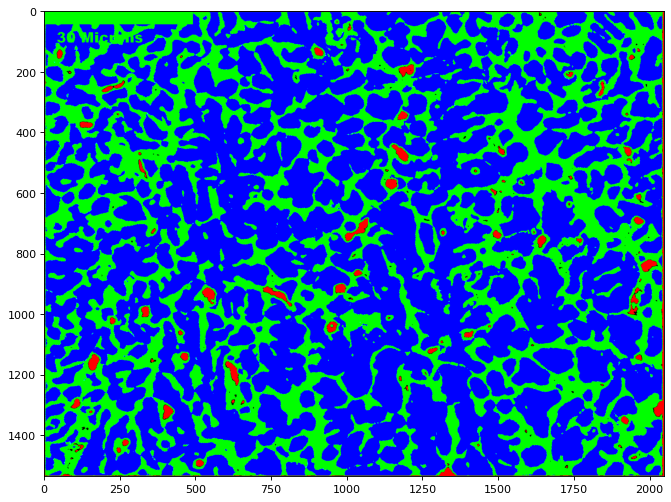

In [123]:
fig = plt.figure(figsize=(10,8), dpi=80)
plt.imshow(raw_rgb,alpha=1)
plt.show()

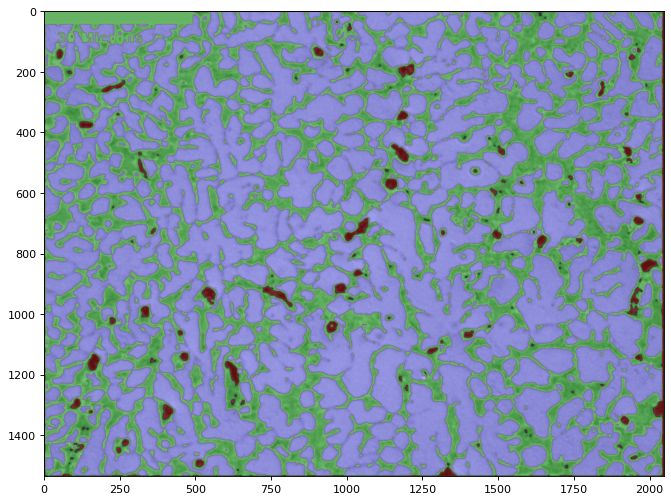

In [124]:
fig = plt.figure(figsize=(10,8), dpi=80)
plt.imshow(clear_rgb,alpha=1)
plt.imshow(src,cmap='gray',alpha=0.7)
plt.show()

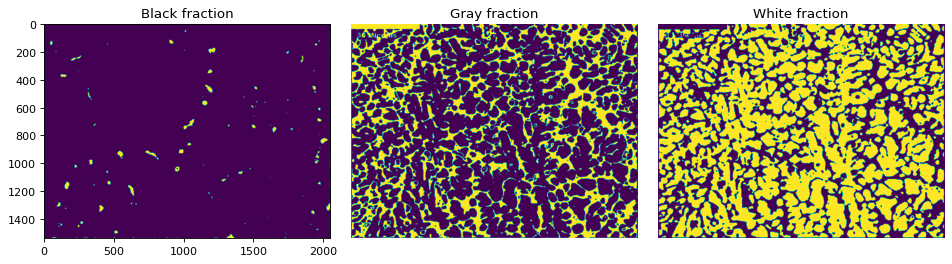

In [125]:
## Calculate areas

# source images
fig = plt.figure(figsize=(12,10), dpi=80)
plt.subplot(131)
plt.imshow(part_1_clear)
plt.title("Black fraction")
plt.subplot(132)
plt.imshow(part_2_clear)
plt.title("Gray fraction")
plt.axis('off')
plt.subplot(133)
plt.imshow(part_3_clear)
plt.title("White fraction")
plt.axis('off')

plt.tight_layout()
plt.show()

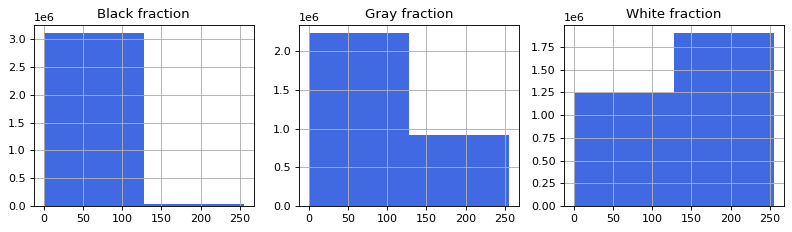

In [127]:
# histograms
fig = plt.figure(figsize=(10,3), dpi=80)
plt.subplot(131)
n1, bins, patches = plt.hist(part_1_clear.reshape(-1,1),bins=2,density=False,facecolor='royalblue')
plt.grid()
plt.title("Black fraction")
plt.subplot(132)
n2, bins, patches = plt.hist(part_2_clear.reshape(-1,1),bins=2,density=False,facecolor='royalblue')
plt.grid()
plt.title("Gray fraction")
plt.subplot(133)
n3, bins, patches = plt.hist(part_3_clear.reshape(-1,1),bins=2,density=False,facecolor='royalblue')
plt.grid()
plt.title("White fraction")

plt.tight_layout()
plt.show()

In [128]:
print(n1)
print(n2)
print(n3)
print('-------------')

IMAGE_AREA = src.shape[0]*src.shape[1]
print(IMAGE_AREA)

[3100583.   45145.]
[2226648.  919080.]
[1246588. 1899140.]
-------------
3145728


In [130]:
print("\nSource image area = {} px".format(IMAGE_AREA))

print("\nTotal 'dark' area = {} px2".format(n1[-1]))
print("Total 'mid' area = {} px2".format(n2[-1]))
print("Total 'light' area = {} px2".format(n3[-1]))

print("\n'Dark' fraction = {} %".format(100*n1[-1]/IMAGE_AREA))
print("'Mid' fraction = {} %".format(100*n2[-1]/IMAGE_AREA))
print("'Light' fraction = {} %".format(100*n3[-1]/IMAGE_AREA))


Source image area = 3145728 px

Total 'dark' area = 45145.0 px2
Total 'mid' area = 919080.0 px2
Total 'light' area = 1899140.0 px2

'Dark' fraction = 1.4351209004720051 %
'Mid' fraction = 29.216766357421875 %
'Light' fraction = 60.37203470865885 %
